# 🧪 Laboratorio Dirigido: Transfer Learning con MobileNetV2

> Clasificador de imágenes de gatos y perros

Este laboratorio completamente guiado te enseñará a aplicar *Transfer Learning* con un modelo preentrenado (MobileNetV2) sobre un conjunto de datos reducido: gatos vs perros.

## 🎯 Objetivos
- Descargar y preparar un dataset reducido de imágenes.
- Reutilizar MobileNetV2 como extractor de características.
- Añadir capas propias para resolver una tarea de clasificación binaria.
- Evaluar el rendimiento y aplicar fine-tuning.

In [38]:
# Paso 1: Importar librerías
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os

In [39]:
# Paso 2: Descargar y preparar el dataset

# Descargar el archivo ZIP
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
zip_path = tf.keras.utils.get_file('cats_and_dogs_filtered.zip', origin=_URL, extract=False)

# Extraer manualmente
import zipfile
extract_path = os.path.join(os.path.dirname(zip_path), 'cats_and_dogs_filtered')
if not os.path.exists(extract_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(os.path.dirname(zip_path))

# Confirmar estructura de carpetas
print("Contenido extraído:", os.listdir(extract_path))
train_dir = os.path.join(extract_path, 'train')
validation_dir = os.path.join(extract_path, 'validation')
print("Train dir:", train_dir)
print("Validation dir:", validation_dir)

Contenido extraído: ['vectorize.py', 'validation', 'train']
Train dir: /root/.keras/datasets/cats_and_dogs_filtered/train
Validation dir: /root/.keras/datasets/cats_and_dogs_filtered/validation


In [40]:
# Paso 3: Preparar datasets de entrenamiento y validación
batch_size = 32
img_size = (160, 160)

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(validation_dir,
    shuffle=True,
    batch_size=batch_size,
    image_size=img_size)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


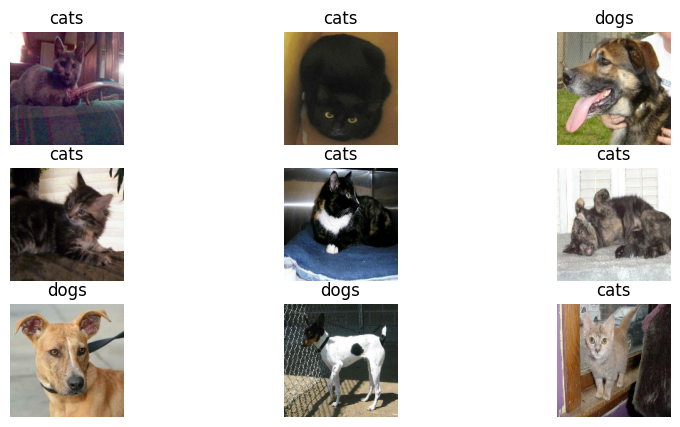

In [41]:
# Paso 4: Visualizar algunas imágenes
class_names = train_dataset.class_names

plt.figure(figsize=(10, 5))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [42]:
# Paso 5: Cargar modelo base MobileNetV2
IMG_SHAPE = img_size + (3,)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

In [43]:
# Paso 6: Crear modelo final con capas propias
from tensorflow.keras import layers, models

# Agregamos la función de preprocesamiento como una capa Lambda
preprocess_layer = layers.Lambda(tf.keras.applications.mobilenet_v2.preprocess_input)

global_average_layer = layers.GlobalAveragePooling2D()
prediction_layer = layers.Dense(1, activation='sigmoid')

model = models.Sequential([
    preprocess_layer,
    base_model,
    global_average_layer,
    prediction_layer
])

In [44]:
# Paso 7: Compilar y entrenar el modelo (solo capas nuevas)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=5)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 68s 989ms/step - accuracy: 0.8266 - loss: 0.3733 - val_accuracy: 0.9740 - val_loss: 0.0869
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 79s 949ms/step - accuracy: 0.9729 - loss: 0.0874 - val_accuracy: 0.9850 - val_loss: 0.0614
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 81s 933ms/step - accuracy: 0.9847 - loss: 0.0590 - val_accuracy: 0.9900 - val_loss: 0.0501
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - accuracy: 0.9863 - loss: 0.0447 - val_accuracy: 0.9900 - val_loss: 0.0448
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 61s 965ms/step - accuracy: 0.9858 - loss: 0.0414 - val_accuracy: 0.9890 - val_loss: 0.0417


In [45]:
# Paso 8: Evaluar resultados
acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Accuracy de entrenamiento: {acc:.2%}")
print(f"Accuracy de validación: {val_acc:.2%}")

Accuracy de entrenamiento: 99.00%
Accuracy de validación: 98.90%


In [46]:
# Paso 9 (opcional): Fine-tuning del modelo base
base_model.trainable = True
fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

fine_tune_epochs = 5
history_fine = model.fit(train_dataset,
                         validation_data=val_dataset,
                         epochs=fine_tune_epochs)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.7972 - loss: 0.4406 - val_accuracy: 0.9730 - val_loss: 0.0615
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - accuracy: 0.9333 - loss: 0.1670 - val_accuracy: 0.9640 - val_loss: 0.0802
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 164s 2s/step - accuracy: 0.9799 - loss: 0.0787 - val_accuracy: 0.9620 - val_loss: 0.0828
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step - accuracy: 0.9729 - loss: 0.0813 - val_accuracy: 0.9620 - val_loss: 0.0806
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step - accuracy: 0.9919 - loss: 0.0456 - val_accuracy: 0.9640 - val_loss: 0.0743


## 📊 Comparación gráfica del rendimiento

A continuación se comparan los resultados de entrenamiento antes y después de aplicar *fine-tuning*. La línea punteada indica el inicio del ajuste fino.

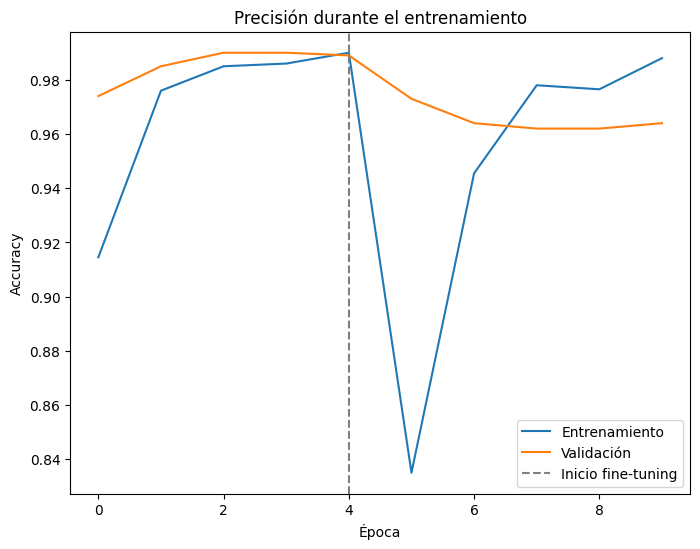

In [47]:
# Extraer métricas
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

acc_fine = history_fine.history['accuracy']
val_acc_fine = history_fine.history['val_accuracy']

# Combinar resultados
total_acc = acc + acc_fine
total_val_acc = val_acc + val_acc_fine

epochs_range = range(len(total_acc))

# Graficar
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 6))
plt.plot(epochs_range, total_acc, label='Entrenamiento')
plt.plot(epochs_range, total_val_acc, label='Validación')
plt.axvline(x=len(acc)-1, color='gray', linestyle='--', label='Inicio fine-tuning')
plt.title('Precisión durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

**Interpretación sugerida:**
- La línea punteada marca el inicio del *fine-tuning*.
- Compara visualmente cómo cambió la precisión en validación.
- Una mejora sostenida después de esa línea indica que el ajuste fino fue efectivo.
- Si no mejora o disminuye, podría ser síntoma de sobreajuste.